In [1]:
import matplotlib.pyplot as plt

In [2]:
import os
# load, split and scale the maps dataset ready for training
from os import listdir

In [3]:
import numpy as np

In [4]:
# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed

C:\Users\kopo\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
from tensorflow.keras.initializers import RandomNormal
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from numpy import load
from numpy import zeros
from numpy import ones

from tensorflow.keras import Input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

In [6]:
import pickle

In [7]:
LOAD_IMG_SIZE = 512

In [8]:
LOAD_IMG_DIM = (LOAD_IMG_SIZE,LOAD_IMG_SIZE)

In [9]:
### 수정필요: 이미지 위치
### ROOT 폴더 내 color, gray 위치

In [10]:
ROOT_IMG_PATH = './문화유산 이미지 자료/train2/'

In [11]:
SRC_FOLDER = "gray"
TAR_FOLDER = "color"

In [12]:
listdir(ROOT_IMG_PATH)

['color', 'gray', '건물', '건물_인물', '기타', '인물', '흑백']

In [13]:
# load all images in a directory into memory
def load_images(inpath, inorgpath, insize, srcFolder, tarFolder):
    src_list, tar_list = [], []
    for filename in listdir(inorgpath):
        try:
            srcpath = os.path.join(inpath,srcFolder,filename)
            tarpath = os.path.join(inpath,tarFolder,filename.replace("_gray","") )
            # 이미지 불러오기 (해상도 적용)
            srcPixels = load_img(srcpath, target_size=insize)
            tarPixels = load_img(tarpath, target_size=insize)
            # 이미지를 array 형태로 변경
            srcPixels = img_to_array(srcPixels)
            tarPixels = img_to_array(tarPixels)
            # 리스트에 이미지 추가
            src_list.append(srcPixels)
            tar_list.append(tarPixels)
        except Exception as e:
            print(e, srcpath)
    print("{} images loaded".format(len(src_list)))
    # 리턴 시 array 로 변환
    return [np.array(src_list), np.array(tar_list)]

In [14]:
# dataset path
orgpath = os.path.join(ROOT_IMG_PATH,SRC_FOLDER)
# load dataset
imgData = load_images(inpath=ROOT_IMG_PATH,
                                       inorgpath = orgpath,
                                       insize=LOAD_IMG_DIM,
                                       srcFolder = SRC_FOLDER,
                                       tarFolder = TAR_FOLDER)

265 images loaded


In [15]:
filename = 'gan_{}.pickle'.format(LOAD_IMG_SIZE)
### 피클 파일 저장하기 (바이너리) ###
with open(filename,"wb") as fw:
    pickle.dump(imgData,fw)

In [16]:
# print('Loaded: ', src_images.shape, tar_images.shape)
# # 압축된 numpy array로 저장
# filename = 'maps_{}.npz'.format(LOAD_IMG_SIZE)
# savez_compressed(filename, src_images, tar_images)
# print('Saved dataset: ', filename)

### 이미지 확인`

In [17]:
with open(filename,"rb") as fr:
    upData = pickle.load(fr)

src_images, tar_images = upData[0], upData[1]
print('Loaded: ', src_images.shape, tar_images.shape)

Loaded:  (265, 512, 512, 3) (265, 512, 512, 3)


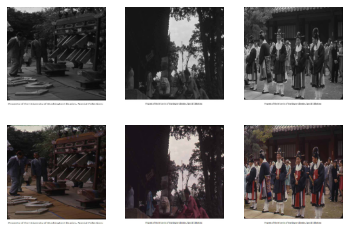

In [18]:
# plot source images
n_samples = 3
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(tar_images[i].astype('uint8'))
plt.show()

###  * PatchGAN은 전체 영역이 아니라 특정 크기의 patch 단위로 Generator가 만든 이미지의 진위 여부를 판단

In [19]:
# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)

    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=image_shape)

    in_src_image

    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])

    # C64
    d = Conv2D(filters=64, kernel_size=4, strides=2, padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(filters=128, kernel_size=4, strides=2, padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(filters=256, kernel_size=4, strides=2, padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(filters=512, kernel_size=4, strides=2, padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(filters=512, kernel_size=4, padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(filters=1, kernel_size=4, padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

### generator

In [20]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# define the standalone generator model
def define_generator(image_shape=(LOAD_IMG_SIZE,LOAD_IMG_SIZE,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

In [21]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy','mae'], optimizer=opt, loss_weights=[1,100])
    return model

In [22]:
# load and prepare training images
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [23]:
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [24]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [25]:
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [26]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, g_loss2, g_loss3 = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f] g[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss, g_loss2, g_loss3))
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)

In [27]:
with open(filename,"rb") as fr:
    dataset = pickle.load(fr)
print('Loaded: ', src_images.shape, tar_images.shape)

Loaded:  (265, 512, 512, 3) (265, 512, 512, 3)


In [28]:
# define input shape based on the loaded dataset
image_shape = dataset[0][0].shape

In [29]:
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

C:\Users\kopo\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [30]:
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

In [ ]:
# train model
train(d_model, g_model, gan_model, dataset, n_epochs=100)

>1, d1[0.252] d2[1.646] g[17056.416] g[1.023] g[170.554]
>2, d1[0.210] d2[1.317] g[8596.033] g[0.576] g[85.955]
>3, d1[0.338] d2[1.231] g[12441.534] g[0.882] g[124.407]
>4, d1[0.272] d2[1.114] g[8243.543] g[0.705] g[82.428]
>5, d1[0.288] d2[0.749] g[6966.986] g[0.966] g[69.660]
>6, d1[0.352] d2[0.602] g[5437.908] g[1.165] g[54.367]
>7, d1[0.526] d2[0.410] g[5371.082] g[1.276] g[53.698]
>8, d1[0.402] d2[0.657] g[17765.830] g[1.186] g[177.646]
>9, d1[0.444] d2[0.566] g[9334.769] g[1.006] g[93.338]
>10, d1[0.491] d2[0.395] g[7552.327] g[1.086] g[75.512]
>11, d1[0.470] d2[0.475] g[9443.027] g[1.155] g[94.419]
>12, d1[0.326] d2[0.589] g[12688.000] g[0.795] g[126.872]
>13, d1[0.338] d2[0.428] g[12164.938] g[0.796] g[121.641]
>14, d1[0.304] d2[0.261] g[4245.410] g[1.326] g[42.441]
>15, d1[0.279] d2[0.241] g[6437.952] g[1.438] g[64.365]
>16, d1[0.311] d2[0.267] g[6528.700] g[1.386] g[65.273]
>17, d1[0.264] d2[0.316] g[7082.265] g[1.334] g[70.809]
>18, d1[0.316] d2[0.428] g[12677.201] g[1.003] 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: plot_002650.png and model_002650.h5
>2651, d1[0.002] d2[0.004] g[4252.375] g[5.117] g[42.473]
>2652, d1[0.001] d2[0.002] g[7863.131] g[5.593] g[78.575]
>2653, d1[0.001] d2[0.003] g[15458.687] g[5.434] g[154.533]
>2654, d1[0.002] d2[0.004] g[5538.602] g[5.335] g[55.333]
>2655, d1[0.001] d2[0.002] g[10564.562] g[5.653] g[105.589]
>2656, d1[0.002] d2[0.004] g[12153.013] g[5.216] g[121.478]
>2657, d1[0.001] d2[0.003] g[8252.374] g[5.475] g[82.469]
>2658, d1[0.001] d2[0.002] g[5511.908] g[5.579] g[55.063]
>2659, d1[0.001] d2[0.004] g[12722.136] g[5.661] g[127.165]
>2660, d1[0.001] d2[0.003] g[11239.396] g[5.343] g[112.341]
>2661, d1[0.001] d2[0.004] g[7626.562] g[5.293] g[76.213]
>2662, d1[0.001] d2[0.003] g[9761.440] g[5.517] g[97.559]
>2663, d1[0.001] d2[0.003] g[12116.616] g[5.589] g[121.110]
>2664, d1[0.002] d2[0.006] g[10636.417] g[5.187] g[106.312]
>2665, d1[0.001] d2[0.003] g[11483.620] g[5.748] g[114.779]
>2666, d1[0.001] d2[0.004] g[10637.512] g[5.427] g[106.321]
>2667, d1[

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: plot_005300.png and model_005300.h5
>5301, d1[0.001] d2[0.001] g[13666.826] g[6.244] g[136.606]
>5302, d1[0.000] d2[0.001] g[12871.631] g[6.245] g[128.654]
>5303, d1[0.000] d2[0.001] g[8869.537] g[6.248] g[88.633]
>5304, d1[0.000] d2[0.001] g[8204.352] g[6.254] g[81.981]
>5305, d1[0.000] d2[0.001] g[9872.330] g[6.330] g[98.660]
>5306, d1[0.000] d2[0.001] g[12117.344] g[6.317] g[121.110]
>5307, d1[0.000] d2[0.001] g[4967.321] g[6.216] g[49.611]
>5308, d1[0.000] d2[0.001] g[9913.859] g[6.312] g[99.075]
>5309, d1[0.001] d2[0.001] g[10254.175] g[6.093] g[102.481]
>5310, d1[0.000] d2[0.001] g[4918.723] g[6.144] g[49.126]
>5311, d1[0.000] d2[0.001] g[11653.492] g[6.263] g[116.472]
>5312, d1[0.000] d2[0.001] g[8869.523] g[6.234] g[88.633]
>5313, d1[0.000] d2[0.001] g[6051.993] g[6.306] g[60.457]
>5314, d1[0.000] d2[0.001] g[8490.009] g[6.261] g[84.837]
>5315, d1[0.000] d2[0.001] g[15195.741] g[6.242] g[151.895]
>5316, d1[0.000] d2[0.001] g[5432.384] g[6.278] g[54.261]
>5317, d1[0.000]

### 디버깅

In [31]:
n_epochs=100
n_batch=1

In [32]:
# determine the output square shape of the discriminator
n_patch = d_model.output_shape[1]
# unpack dataset
trainA, trainB = dataset
# calculate the number of batches per training epoch
bat_per_epo = int(len(trainA) / n_batch)
# calculate the number of training iterations
n_steps = bat_per_epo * n_epochs

In [33]:
i=0

In [60]:
# select a batch of real samples
[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
# generate a batch of fake samples
X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
# update discriminator for real samples
d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
# update discriminator for generated samples
d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
# update the generator
g_loss, _, _= gan_model.train_on_batch(X_realA, [y_real, X_realB])
# summarize performance
print('>%d, d1[%.3f] d2[%.3f] g[%.3f] g[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss, g_l1, g_l2))
# summarize model performance
if (i+1) % (bat_per_epo * 10) == 0:
    summarize_performance(i, g_model, dataset)

ResourceExhaustedError:  OOM when allocating tensor with shape[1,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_5/model/conv2d/Conv2D (defined at \AppData\Local\Temp/ipykernel_12412/2463806602.py:10) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_13194]

Function call stack:
train_function


In [ ]:
# determine the output square shape of the discriminator
n_patch = d_model.output_shape[1]
# unpack dataset
trainA, trainB = dataset
# calculate the number of batches per training epoch
bat_per_epo = int(len(trainA) / n_batch)
# calculate the number of training iterations
n_steps = bat_per_epo * n_epochs
# manually enumerate epochs
for i in range(n_steps):
    # select a batch of real samples
    [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
    # generate a batch of fake samples
    X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
    # update discriminator for real samples
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
    # update discriminator for generated samples
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
    # update the generator
    g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
    # summarize performance
    print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
    # summarize model performance
    if (i+1) % (bat_per_epo * 10) == 0:
        summarize_performance(i, g_model, dataset)

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)

In [42]:
d_model = d_model
g_model = g_model
gan_model = gan_model
n_epochs=10

In [43]:
d_model.output_shape

(None, 32, 32, 1)

In [44]:
# determine the output square shape of the discriminator
n_patch = d_model.output_shape[1]

In [45]:
n_patch

32

In [46]:
# determine the output square shape of the discriminator
n_patch = d_model.output_shape[1]
# unpack dataset
trainA, trainB = dataset

In [51]:
n_batch=1

In [52]:
# calculate the number of batches per training epoch
bat_per_epo = int(len(trainA) / n_batch)

In [53]:
# calculate the number of training iterations
n_steps = bat_per_epo * n_epochs

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [94]:
# generate fake instance
X = g_model.predict(samples)

NameError: name 'samples' is not defined

In [ ]:
# create 'fake' class labels (0)
y = zeros((len(X), patch_shape, patch_shape, 1))
return X, y

In [95]:
[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)

In [96]:
X = g_model.predict(X_realA)

In [97]:
X.shape

(1, 512, 512, 3)

In [98]:
n_patch

32

In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [72]:
X1, X2 = trainA[ix], trainB[ix]

In [ ]:
generate_real_samples(dataset, n_batch, n_patch)

In [ ]:
# manually enumerate epochs
for i in range(n_steps):
    # select a batch of real samples [원본/타겟], discriminator ouput shape 1,32,32, 1
    [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
    # generate a batch of fake samples [원본이미지로 g_model 넣고 생성된 이미지, discriminator ouput shape 1,32,32, 1
    X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
    # update discriminator for real samples
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
    # update discriminator for generated samples
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
    # update the generator
    g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
    # summarize performance
    print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
    # summarize model performance
    if (i+1) % (bat_per_epo * 10) == 0:
        summarize_performance(i, g_model, dataset)

In [ ]:
# calculate the number of batches per training epoch
bat_per_epo = int(len(trainA) / n_batch)
# calculate the number of training iterations
n_steps = bat_per_epo * n_epochs
# manually enumerate epochs
for i in range(n_steps):
    # select a batch of real samples
    [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
    # generate a batch of fake samples
    X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
    # update discriminator for real samples
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
    # update discriminator for generated samples
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
    # update the generator
    g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
    # summarize performance
    print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
    # summarize model performance
    if (i+1) % (bat_per_epo * 10) == 0:
        summarize_performance(i, g_model, dataset)

In [102]:
bat_per_epo

100

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)

In [26]:
# train model
train(d_model, g_model, gan_model, dataset, n_epochs=10)

>1, d1[0.404] d2[0.719] g[73.559]
>2, d1[0.589] d2[0.667] g[57.254]
>3, d1[1.123] d2[0.544] g[49.406]
>4, d1[0.440] d2[0.608] g[43.515]
>5, d1[0.362] d2[0.497] g[37.241]
>6, d1[0.450] d2[0.500] g[29.613]
>7, d1[0.389] d2[0.396] g[45.228]
>8, d1[0.379] d2[0.394] g[29.659]
>9, d1[0.380] d2[0.372] g[40.541]
>10, d1[0.382] d2[0.395] g[29.883]
>11, d1[0.370] d2[0.383] g[39.809]
>12, d1[0.375] d2[0.399] g[26.015]
>13, d1[0.367] d2[0.376] g[22.101]
>14, d1[0.382] d2[0.419] g[20.004]
>15, d1[0.379] d2[0.384] g[24.521]
>16, d1[0.418] d2[0.371] g[24.874]
>17, d1[0.383] d2[0.381] g[33.813]
>18, d1[0.383] d2[0.417] g[22.216]
>19, d1[0.377] d2[0.394] g[19.609]
>20, d1[0.386] d2[0.368] g[25.791]
>21, d1[0.389] d2[0.383] g[18.662]
>22, d1[0.369] d2[0.382] g[27.858]
>23, d1[0.380] d2[0.382] g[26.179]
>24, d1[0.367] d2[0.371] g[33.005]
>25, d1[0.398] d2[0.367] g[23.603]
>26, d1[0.378] d2[0.380] g[22.863]
>27, d1[0.362] d2[0.386] g[23.345]
>28, d1[0.375] d2[0.353] g[17.603]
>29, d1[0.370] d2[0.388] g[17